In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from heston import UnivariateHestonSV, MultivariateHestonSV
from heston import make_surface, bs_call_px, structure_constructor

## Market Implied Surface

In [2]:
data = pd.read_excel('data/equities.xlsx', index_col=0)
assets = data.corp.unique()
data.head()

assets = data.corp.unique()
mv_hes_mkt_implied = MultivariateHestonSV(assets)
mv_hes_mkt_implied.set_params(
    {
        # parameters list: ['kappa', 'v0', 'theta', 'eta', 'rho_sv']
        assets[0]: [12.22153077,  0.19999999,  0.10679624,  1.11942453, -0.79999979],
        assets[1]: [ 0.69115605,  0.11214887,  0.4196924 ,  0.19383575, -0.79890507],
        assets[2]: [ 2.0236936 ,  0.14899818,  0.30447942,  0.4452153 , -0.79999991],
        # risk free rate
        'r': 0.045,
        # stock covariance matrix
        'cov_s': np.array([
            [1, 0.3, 0.3],
            [0.3, 1, 0.3],
            [0.3, 0.3, 1]
        ])
    }
)

## Perturbed Surface - Precalibrated

In [75]:
assets = data.corp.unique()
mv_hes_perturbed = MultivariateHestonSV(assets)
mv_hes_perturbed.set_params(
    {
        # parameters list: ['kappa', 'v0', 'theta', 'eta', 'rho_sv']
        assets[0]: [6.06447103,  0.15058895,  0.10798075,  0.64123972, -0.79929272],
        assets[1]: [ 0.70732155,  0.111646,    0.41990275,  0.20931289, -0.79999965],
        assets[2]: [ 1.88121426,  0.15271228,  0.30905064,  0.44772211, -0.79991312],
        # risk free rate
        'r': 0.045,
        # stock covariance matrix
        'cov_s': np.array([
            [1, 0.3, 0.3],
            [0.3, 1, 0.3],
            [0.3, 0.3, 1]
        ])
    }
)

## Use this Cell to Recalibrate everything again (Kinda Slow)

In [71]:
perturbed_data = mv_hes.make_perturbed_surface_knots(
    np.array([34, 15, 25]), 
    knots = [
        (np.linspace(34-5*2, 34+5*2, 5), np.linspace(2-0.5*3, 2+0.5*1, 5)),
        (np.linspace(15-5*2, 15+5*2, 5), np.linspace(2-0.5*3, 2+0.5*1, 5)),
        (np.linspace(25-5*2, 25+5*2, 5), np.linspace(2-0.5*3, 2+0.5*1, 5))],
    bump_points = [(34,2), (15,2), (25,2)],
    rotations = [
        {(44, 2): -0.005, (24, 2): 0.005},
        {(25, 2): -0.005, (5, 2): 0.005},
        {(35, 2): -0.005, (15, 2): 0.005}
    ]
)

100% (3 of 3) |###########################| Elapsed Time: 0:00:01 Time: 0:00:01


In [73]:
mv_perturb = MultivariateHestonSV(data.corp.unique())
fit_perturb = mv_perturb.calibrate(
    perturbed_data, px=[34,15,25], r=[0.045]*3,
    cov_s=np.array([
        [1, 0.3, 0.3],
        [0.3, 1, 0.3],
        [0.3, 0.3, 1]
    ])
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9985e+01                                    9.76e+01    
       1              2         3.6949e+00      1.63e+01       4.88e-01       9.90e+00    
       2              3         7.9762e-01      2.90e+00       4.59e-01       4.87e+00    
       3              4         3.8941e-01      4.08e-01       3.11e-01       2.17e+00    
       4              5         1.7022e-01      2.19e-01       5.60e-01       4.72e+00    
       5              6         8.5332e-02      8.49e-02       2.02e-01       1.15e+00    
       6              7         6.4418e-02      2.09e-02       2.15e-01       4.63e+00    
       7              9         5.0394e-02      1.40e-02       2.58e-01       1.93e+00    
       8             10         4.3427e-02      6.97e-03       6.87e-01       8.05e+00    
       9             11         2.8069e-02      1.54e-02       9.40e-01       5.80e+00    

## Do valuations using same dW drivers

In [4]:
s_0 = np.array([34, 15, 25]) # time-0 stock price
# use pre-computed paths to speed things up
n_paths = 5000
n_nodes = 252*2
n_assets = 3

drivers = np.random.multivariate_normal(np.array(
    [0] * (2 * n_assets)), mv_hes_mkt_implied.cov, (n_nodes, n_paths))

#paths_perturbed = mv_hes_perturbed.simulate_paths_cfb_given_dW(
#    n_paths=n_paths, n_nodes=n_nodes, T=2, dS=1e-4, S0=s_0, dWs=drivers)

In [5]:
# market implied path, using same drivers
paths_mkt_implied = mv_hes_mkt_implied.simulate_paths_cfb_given_dW(
    n_paths=n_paths, n_nodes=n_nodes, T=2, dS=1e-4, S0=s_0, dWs=drivers)

100% (5000 of 5000) |#####################| Elapsed Time: 0:07:31 Time: 0:07:31


In [8]:
import pickle
s_0 = np.array([34, 15, 25]) # time-0 stock price
# use pre-computed paths to speed things up
n_paths = 5000
n_nodes = 252*2
n_assets = 3
paths_mkt_implied = pickle.load(open('paths.p', 'rb'))

In [6]:
from heston import structure_constructor_best_KI
def portfolio(model, paths, K, D, x, R, p):
    loss, structure, pct_adv, cap, deltas, slip = structure_constructor_best_KI(
        model=model, x=x, put_Ks=K, Ds=D, R_req=R, adv=adv, 
        adv_thres=0.3, S0=s_0, cap_required=100, alpha=0.1, pre_computed_paths=paths, 
        premiums=p)
    delta_collar, delta_boc, delta_KI = deltas
    delta_tot = delta_collar-delta_boc+delta_KI
    # print(structure)
    print('Put Strikes:', K)
    print('Shares:', x)
    print('Loss:', loss)
    print('|X/ADV|:', np.abs(pct_adv))
    print('Price Slippage', slip)
    print('Pct Price Slippage (BPs)', (slip/s_0)*1e4)
    print('Dollar Slippage', slip.dot(delta_tot.reshape(3,))[0])
    print('Dollar Premium', -p[0].dot(x)+p[1])
    print('Locked-in Capital:', cap)
    print('Deltas/Sell x Collar:', delta_collar)
    print('Deltas/Sell 1 Best of Call:', -delta_boc)
    print('Deltas/Buy 1 KI:', delta_KI)
    print('Deltas/Entire Structure:', delta_tot)
    return structure

## Valuation under Perturbed Surface $\mathcal{M}_1$

In [31]:
adv = data.adv.unique() / 1e6
Kput = np.array([31.0, 11.0, 21.5])
D = np.array([2, 2, 3])
x = np.array([-0.3, -6, -1.73])
R = 0.05
shadow_barrier = np.abs(np.sum(D*x)*0.025)
cost = (np.array([0.2, 0.1, 0.2]), shadow_barrier+0.66)


structure = portfolio(mv_hes_mkt_implied, paths_mkt_implied, Kput, D, x, R, cost)
print('----------------------------------------------')
for name, obj in structure.items():
    print(repr(obj))

Put Strikes: [31.  11.  21.5]
Shares: [-0.3  -6.   -1.73]
Loss: 0.48760602139802034
|X/ADV|: [[0.56010849 0.58465124 0.5984575 ]]
Price Slippage [[1.16322152 0.40200968 0.79079333]]
Pct Price Slippage (BPs) [[342.12397513 268.00645122 316.31733191]]
Dollar Slippage 0.6643051621890395
Dollar Premium 2.1107500000000003
Locked-in Capital: 102.81268868708682
Deltas/Sell x Collar: [[0.1857513  1.78956496 1.02472213]]
Deltas/Sell 1 Best of Call: [[-0.05799156 -0.8231643  -0.46938854]]
Deltas/Buy 1 KI: [[-0.0062162  -0.60976341 -0.07537068]]
Deltas/Entire Structure: [[0.12154354 0.35663725 0.47996291]]
----------------------------------------------
Zero Cost Collar:
+ MultiAssetsAsianPut: K=[31.000, 11.000, 21.500], T=2
- MultiAssetsAsianCall: K=[40.006, 22.564, 32.296], T=2
MultiAssetsBestOfAsianCall: K=[40.006, 22.564, 32.296], R_required=0.05, T_entry=1, T_mature=2
MultiAssetsBestOfDiscreteKIEuropeanPut: K=[31.370, 21.022, 25.393], H=[29.370, 19.022, 22.393], T_entry=1, T_mature=2


## Initial terms

In [50]:
adv = data.adv.unique() / 1e6
Kput = np.array([31.5, 10.05, 22])
D = np.array([2, 5, 1.8])
x = np.array([-0.4, -5.7, -1.83])
R = 0.05
shadow_barrier = np.abs(np.sum(D*x)*0.025)
cost = (np.array([0.2, 0.1, 0.2]), shadow_barrier+1.2)


structure = portfolio(mv_hes_mkt_implied, paths_mkt_implied, Kput, D, x, R, cost)
print('----------------------------------------------')
for name, obj in structure.items():
    print(repr(obj))

Put Strikes: [31.5  10.05 22.  ]
Shares: [-0.4  -5.7  -1.83]
Loss: 0.5774909544848019
|X/ADV|: [[0.79208544 0.09008287 0.60223785]]
Price Slippage [[1.59994636 0.         0.79578578]]
Pct Price Slippage (BPs) [[470.57245867   0.         318.31431257]]
Dollar Slippage 0.6593632055363324
Dollar Premium 3.03085
Locked-in Capital: 100.66495040169944
Deltas/Sell x Collar: [[0.26236588 1.19368262 1.14732489]]
Deltas/Sell 1 Best of Call: [[-0.07994614 -0.6164738  -0.51446751]]
Deltas/Buy 1 KI: [[-0.01053719 -0.52225828 -0.14986263]]
Deltas/Entire Structure: [[0.17188254 0.05495055 0.48299476]]
----------------------------------------------
Zero Cost Collar:
+ MultiAssetsAsianPut: K=[31.500, 10.050, 22.000], T=2
- MultiAssetsAsianCall: K=[39.455, 24.224, 31.569], T=2
MultiAssetsBestOfAsianCall: K=[39.455, 24.224, 31.569], R_required=0.05, T_entry=1, T_mature=2
MultiAssetsBestOfDiscreteKIEuropeanPut: K=[32.764, 21.116, 31.322], H=[30.764, 16.116, 29.522], T_entry=1, T_mature=2


In [59]:
x

array([-0.4 , -5.7 , -1.83])

In [63]:
s_0

array([34, 15, 25])

In [64]:
np.linspace(34-5*2, 34+5*2, 5)

array([24., 29., 34., 39., 44.])

In [66]:
34-6

28

In [174]:
-0.1*p1.delta(s_0[0]),-0.57*p2.delta(s_0[1])

(0.020395478109946907, 0.029992364817310598)

In [185]:
np.append(np.linspace(34*0.85, 34*1.2, 5), 34)

array([28.9  , 31.875, 34.85 , 37.825, 40.8  , 34.   ])

In [189]:
deltas = []
deltas_after_hedge = []
deltas_zc = []
deltas_boc = []
deltas_ki = []
drivers = np.random.multivariate_normal(np.array(
        [0] * (2 * n_assets)), mv_hes_mkt_implied.cov, (64, 1000))

for s1 in np.append(np.linspace(34*0.85, 34*1.2, 5), 34):
    s_0 = np.array([34, 15, 25])
    s_0[0] = s1
    

    paths = mv_hes_mkt_implied.simulate_paths_cfb_given_dW(
        n_paths=1000, n_nodes=64, T=2, dS=1e-4, S0=s_0, dWs=drivers)

    SSc, SSf, SSb, XXc, XXf, XXb, VV = paths_mkt_implied
    paths_c = (SSc, XXc, VV)
    
    p1 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[0]], 30, 0.5)
    p2 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[1]], 10, 0.5)
    p3 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[2]], 20, 0.5)
    zcollar = structure['Zero Collar']
    zcollar.spots = s_0
    boc = structure['Best of Call']
    boc.S_init = s_0
    ki = structure['Best of KI Put']
    ki.S_init = s_0

    delta_zcollar = zcollar.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_boc = boc.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_KI = ki.mc_delta(spots=s_0, pre_computed_paths=paths)
    dp1 = -0.1*p1.delta(s_0[0])
    dp2 = -0.57*p2.delta(s_0[1])
    dp3 = -(55/1000)*p3.delta(s_0[2])
    dd = np.diag(delta_zcollar)*x - delta_boc + delta_KI
    dd_after = np.copy(dd)
    dd_after[0,0] += dp1
    dd_after[0,1]+= dp2
    dd_after[0,2] +=dp3
    print(np.diag(delta_zcollar))
    print(delta_boc)
    print(delta_KI)
    print(dd, np.diag(delta_zcollar))
    print(dd_after)
    deltas.append(dd)
    deltas_after_hedge.append(dd_after)
    deltas_zc.append(delta_zcollar*x[0])
    deltas_boc.append(-delta_boc)
    deltas_ki.append(delta_KI)


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (13 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:07

[-0.67693168 -0.23515313 -0.64246769]
[[0.04138197 0.74372685 0.48717849]]
[[-0.02150349 -0.42035887 -0.14322196]]
[[0.20788721 0.17628714 0.54531543]] [-0.67693168 -0.23515313 -0.64246769]
[[0.25631044 0.20627951 0.55415304]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:07 Time: 0:00:07
  1% (13 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:07

[-0.63555576 -0.23515313 -0.64246769]
[[0.06765344 0.74372685 0.48717849]]
[[-0.01464662 -0.42035887 -0.14322196]]
[[0.17192224 0.17628714 0.54531543]] [-0.63555576 -0.23515313 -0.64246769]
[[0.2037851  0.20627951 0.55415304]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (13 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.66464681 -0.23515313 -0.64246769]
[[0.08631413 0.74372685 0.48717849]]
[[-0.01093255 -0.42035887 -0.14322196]]
[[0.16861204 0.17628714 0.54531543]] [-0.66464681 -0.23515313 -0.64246769]
[[0.18900752 0.20627951 0.55415304]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:09 Time: 0:00:09
  1% (10 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:09

[-0.71405215 -0.23515313 -0.64246769]
[[0.10220509 0.74372685 0.48717849]]
[[-0.00696947 -0.42035887 -0.14322196]]
[[0.1764463  0.17628714 0.54531543]] [-0.71405215 -0.23515313 -0.64246769]
[[0.18940789 0.20627951 0.55415304]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:09 Time: 0:00:09
  1% (13 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:07

[-0.75499579 -0.23515313 -0.64246769]
[[0.10902322 0.74372685 0.48717849]]
[[-0.00512266 -0.42035887 -0.14322196]]
[[0.18785244 0.17628714 0.54531543]] [-0.75499579 -0.23515313 -0.64246769]
[[0.19612409 0.20627951 0.55415304]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:07 Time: 0:00:07


[-0.66464681 -0.23515313 -0.64246769]
[[0.08631413 0.74372685 0.48717849]]
[[-0.01093255 -0.42035887 -0.14322196]]
[[0.16861204 0.17628714 0.54531543]] [-0.66464681 -0.23515313 -0.64246769]
[[0.18900752 0.20627951 0.55415304]]


In [199]:
deltas2 = []
deltas_after_hedge2 = []
deltas_zc = []
deltas_boc = []
deltas_ki = []
drivers = np.random.multivariate_normal(np.array(
        [0] * (2 * n_assets)), mv_hes_mkt_implied.cov, (64, 1000))

for s1 in np.append(np.linspace(15*0.85, 15*1.2, 5), 15):
    s_0 = np.array([34, 15, 25])
    s_0[1] = s1
    

    paths = mv_hes_mkt_implied.simulate_paths_cfb_given_dW(
        n_paths=1000, n_nodes=64, T=2, dS=1e-4, S0=s_0, dWs=drivers)

    SSc, SSf, SSb, XXc, XXf, XXb, VV = paths_mkt_implied
    paths_c = (SSc, XXc, VV)
    
    p1 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[0]], 30, 0.5)
    p2 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[1]], 10, 0.5)
    p3 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[2]], 20, 0.5)
    zcollar = structure['Zero Collar']
    zcollar.spots = s_0
    boc = structure['Best of Call']
    boc.S_init = s_0
    ki = structure['Best of KI Put']
    ki.S_init = s_0

    delta_zcollar = zcollar.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_boc = boc.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_KI = ki.mc_delta(spots=s_0, pre_computed_paths=paths)
    dp1 = -0.1*p1.delta(s_0[0])
    dp2 = -0.57*p2.delta(s_0[1])
    dp3 = -(55/1000)*p3.delta(s_0[2])
    dd = np.diag(delta_zcollar)*x - delta_boc + delta_KI
    dd_after = np.copy(dd)
    dd_after[0,0] += dp1
    dd_after[0,1]+= dp2
    dd_after[0,2] +=dp3
    print(np.diag(delta_zcollar))
    print(delta_boc)
    print(delta_KI)
    print(dd, np.diag(delta_zcollar))
    print(dd_after)
    deltas2.append(dd)
    deltas_after_hedge2.append(dd_after)
    deltas_zc.append(delta_zcollar*x[0])
    deltas_boc.append(-delta_boc)
    deltas_ki.append(delta_KI)

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.67720751 -0.22325579 -0.60561443]
[[0.08651953 0.15312757 0.46398067]]
[[-0.00922141 -0.90813701 -0.13872367]]
[[0.17514206 0.21129343 0.50557005]] [-0.67720751 -0.22325579 -0.60561443]
[[0.19553754 0.31543882 0.51440766]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.67720751 -0.18531713 -0.60561443]
[[0.08651953 0.38565892 0.46398067]]
[[-0.00922141 -0.6197016  -0.13872367]]
[[0.17514206 0.05094711 0.50557005]] [-0.67720751 -0.18531713 -0.60561443]
[[0.19553754 0.09657736 0.51440766]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.67720751 -0.19006806 -0.60561443]
[[0.08651953 0.54218585 0.46398067]]
[[-0.00922141 -0.55402349 -0.13872367]]
[[ 0.17514206 -0.01282139  0.50557005]] [-0.67720751 -0.19006806 -0.60561443]
[[0.19553754 0.01717097 0.51440766]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.67720751 -0.20840971 -0.60561443]
[[0.08651953 0.67189015 0.46398067]]
[[-0.00922141 -0.46178315 -0.13872367]]
[[0.17514206 0.05426204 0.50557005]] [-0.67720751 -0.20840971 -0.60561443]
[[0.19553754 0.07398739 0.51440766]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.67720751 -0.27655505 -0.60561443]
[[0.08651953 0.98415633 0.46398067]]
[[-0.00922141 -0.31431097 -0.13872367]]
[[0.17514206 0.27789645 0.50557005]] [-0.67720751 -0.27655505 -0.60561443]
[[0.19553754 0.28652186 0.51440766]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08


[-0.67720751 -0.19006806 -0.60561443]
[[0.08651953 0.54218585 0.46398067]]
[[-0.00922141 -0.55402349 -0.13872367]]
[[ 0.17514206 -0.01282139  0.50557005]] [-0.67720751 -0.19006806 -0.60561443]
[[0.19553754 0.01717097 0.51440766]]


In [209]:
deltas3 = []
deltas_after_hedge3 = []
deltas_zc = []
deltas_boc = []
deltas_ki = []
drivers = np.random.multivariate_normal(np.array(
        [0] * (2 * n_assets)), mv_hes_mkt_implied.cov, (64, 1000))

for s1 in np.append(np.linspace(25*0.8, 25*1.2, 5), 25):
    s_0 = np.array([34, 15, 25])
    s_0[2] = s1
    

    paths = mv_hes_mkt_implied.simulate_paths_cfb_given_dW(
        n_paths=1000, n_nodes=64, T=2, dS=1e-4, S0=s_0, dWs=drivers)

    SSc, SSf, SSb, XXc, XXf, XXb, VV = paths_mkt_implied
    paths_c = (SSc, XXc, VV)
    
    p1 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[0]], 30, 0.5)
    p2 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[1]], 10, 0.5)
    p3 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[2]], 20, 0.5)
    zcollar = structure['Zero Collar']
    zcollar.spots = s_0
    boc = structure['Best of Call']
    boc.S_init = s_0
    ki = structure['Best of KI Put']
    ki.S_init = s_0

    delta_zcollar = zcollar.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_boc = boc.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_KI = ki.mc_delta(spots=s_0, pre_computed_paths=paths)
    dp1 = -0.1*p1.delta(s_0[0])
    dp2 = -0.57*p2.delta(s_0[1])
    dp3 = -(55/1000)*p3.delta(s_0[2])
    dd = np.diag(delta_zcollar)*x - delta_boc + delta_KI
    dd_after = np.copy(dd)
    dd_after[0,0] += dp1
    dd_after[0,1]+= dp2
    dd_after[0,2] +=dp3
    print(np.diag(delta_zcollar))
    print(delta_boc)
    print(delta_KI)
    print(dd, np.diag(delta_zcollar))
    print(dd_after)
    deltas3.append(dd)
    deltas_after_hedge3.append(dd_after)
    deltas_zc.append(delta_zcollar*x[0])
    deltas_boc.append(-delta_boc)
    deltas_ki.append(delta_KI)

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  0% (9 of 1000) |                        | Elapsed Time: 0:00:00 ETA:  0:00:12

[-0.61059205 -0.21949778 -0.62453629]
[[0.06877604 0.64731787 0.29365832]]
[[-0.01177478 -0.51885514 -0.26387284]]
[[0.16368601 0.08496432 0.58537025]] [-0.61059205 -0.21949778 -0.62453629]
[[0.18408149 0.11495668 0.60586474]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.61059205 -0.21949778 -0.6122872 ]
[[0.06877604 0.64731787 0.39213935]]
[[-0.01177478 -0.51885514 -0.20694028]]
[[0.16368601 0.08496432 0.52140595]] [-0.61059205 -0.21949778 -0.6122872 ]
[[0.18408149 0.11495668 0.53612745]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (10 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:10

[-0.61059205 -0.21949778 -0.63066295]
[[0.06877604 0.64731787 0.51522321]]
[[-0.01177478 -0.51885514 -0.15591848]]
[[0.16368601 0.08496432 0.48297151]] [-0.61059205 -0.21949778 -0.63066295]
[[0.18408149 0.11495668 0.49180912]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.61059205 -0.21949778 -0.64672764]
[[0.06877604 0.64731787 0.57218032]]
[[-0.01177478 -0.51885514 -0.1259507 ]]
[[0.16368601 0.08496432 0.48538056]] [-0.61059205 -0.21949778 -0.64672764]
[[0.18408149 0.11495668 0.49166832]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.61059205 -0.21949778 -0.69721943]
[[0.06877604 0.64731787 0.65597882]]
[[-0.01177478 -0.51885514 -0.09508761]]
[[0.16368601 0.08496432 0.52484513]] [-0.61059205 -0.21949778 -0.69721943]
[[0.18408149 0.11495668 0.52865016]]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08


[-0.61059205 -0.21949778 -0.63066295]
[[0.06877604 0.64731787 0.51522321]]
[[-0.01177478 -0.51885514 -0.15591848]]
[[0.16368601 0.08496432 0.48297151]] [-0.61059205 -0.21949778 -0.63066295]
[[0.18408149 0.11495668 0.49180912]]


In [207]:
dd2

[-0.3068990829444562,
 -0.40223756364971,
 -0.4419328109244973,
 -0.4528927276433281,
 -0.3692204226563911]

In [208]:
deltas_after_hedge3

[array([[0.18088538, 0.04809676, 0.61158703]]),
 array([[0.18088538, 0.04809676, 0.51624855]]),
 array([[0.18088538, 0.04809676, 0.47655331]]),
 array([[0.18088538, 0.04809676, 0.46559339]]),
 array([[0.18088538, 0.04809676, 0.54926569]]),
 array([[0.18088538, 0.04809676, 0.91848612]])]

/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  import sys
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2

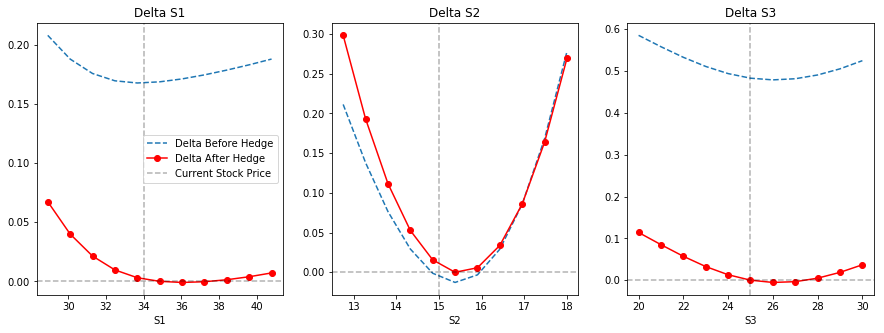

In [214]:
from scipy import interpolate
fig, axes = plt.subplots(1,3,figsize=(15,5))
ss =np.linspace(34*0.85, 34*1.2, 5)
ss2 = np.linspace(34*0.85, 34*1.2, 11)
dd = [x[0,0] for x in deltas[:-1]]
dd2 = [x[0,0]-deltas_after_hedge[-1][0,0] for x in deltas_after_hedge[:-1]]
yy = interpolate.spline(ss,dd,ss2)
yy2 = interpolate.spline(ss,dd2,ss2)
axes[0].plot(ss2,yy,'--', label='Delta Before Hedge')
axes[0].plot(ss2,yy2,'o-', color='red',label='Delta After Hedge')
#axes[0].plot(ss,dd,'o-')

ss =np.linspace(15*0.85, 15*1.2, 5)
ss2 = np.linspace(15*0.85, 15*1.2, 11)
dd = [x[0,1] for x in deltas2[:-1]]
dd2 = [x[0,1]-deltas_after_hedge2[-1][0,1] for x in deltas_after_hedge2[:-1]]
yy = interpolate.spline(ss,dd,ss2)
yy2 = interpolate.spline(ss,dd2,ss2)
axes[1].plot(ss2,yy,'--')
axes[1].plot(ss2,yy2,'o-', color='red',label='Delta After Hedge')
#axes[1].plot(ss,dd,'o-')

ss =np.linspace(25*0.8, 25*1.2, 5)
ss2 = np.linspace(25*0.8, 25*1.2, 11)
dd = [x[0,2] for x in deltas3[:-1]]
dd2 = [x[0,2]-deltas_after_hedge3[-1][0,2] for x in deltas_after_hedge3[:-1]]
yy = interpolate.spline(ss,dd,ss2)
yy2 = interpolate.spline(ss,dd2,ss2)
axes[2].plot(ss2,yy,'--')
axes[2].plot(ss2,yy2,'o-', color='red',label='Delta After Hedge')
#axes[2].plot(ss,dd,'o-')
axes[0].set_title('Delta S1')
axes[1].set_title('Delta S2')
axes[2].set_title('Delta S3')
axes[0].set_xlabel('S1')
axes[1].set_xlabel('S2')
axes[2].set_xlabel('S3')
axes[0].axvline(34, linestyle='--', color='black', alpha=0.3, label='Current Stock Price')
axes[1].axvline(15, linestyle='--', color='black', alpha=0.3)
axes[2].axvline(25, linestyle='--', color='black', alpha=0.3)
axes[0].axhline(0,  linestyle='--', color='black', alpha=0.3)
axes[1].axhline(0,  linestyle='--', color='black', alpha=0.3)
axes[2].axhline(0,  linestyle='--', color='black', alpha=0.3)
axes[0].legend()

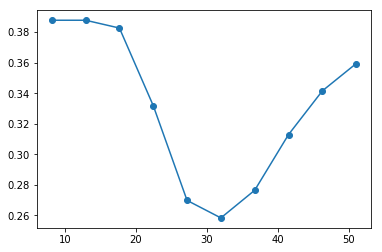

In [127]:
from scipy import interpolate
dd = [x[0,0] for x in deltas_zc[1:]]
ss =np.linspace(34*0.1, 34*1.5, 11)[1:]
#ss2 = np.linspace(34*0.9, 34*1.1, 21)
#yy = interpolate.spline(ss,dd,ss2)
plt.plot(ss,dd,'o-')

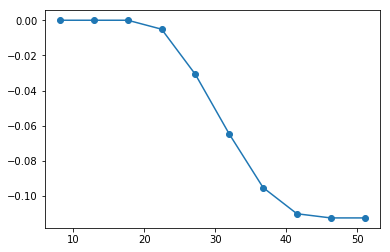

In [128]:
dd = [x[0,0] for x in deltas_boc[1:]]
ss =np.linspace(34*0.1, 34*1.5, 11)[1:]
#ss2 = np.linspace(34*0.9, 34*1.1, 21)
#yy = interpolate.spline(ss,dd,ss2)
plt.plot(ss,dd,'o-')

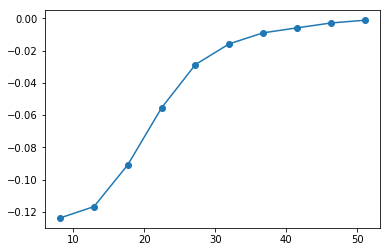

In [129]:
dd = [x[0,0] for x in deltas_ki[1:]]
ss =np.linspace(34*0.1, 34*1.5, 11)[1:]
#ss2 = np.linspace(34*0.9, 34*1.1, 21)
#yy = interpolate.spline(ss,dd,ss2)
plt.plot(ss,dd,'o-')

/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """


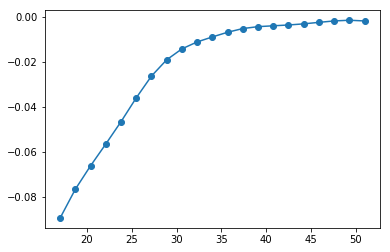

In [123]:
from scipy import interpolate
dd = [x[0,0] for x in deltas_ki]
ss =np.linspace(34*0.5, 34*1.5, 11)
ss2 = np.linspace(34*0.5, 34*1.5, 21)
yy = interpolate.spline(ss,dd,ss2)
plt.plot(ss2,yy,'o-')

/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  import sys
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  del sys.path[0]
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()


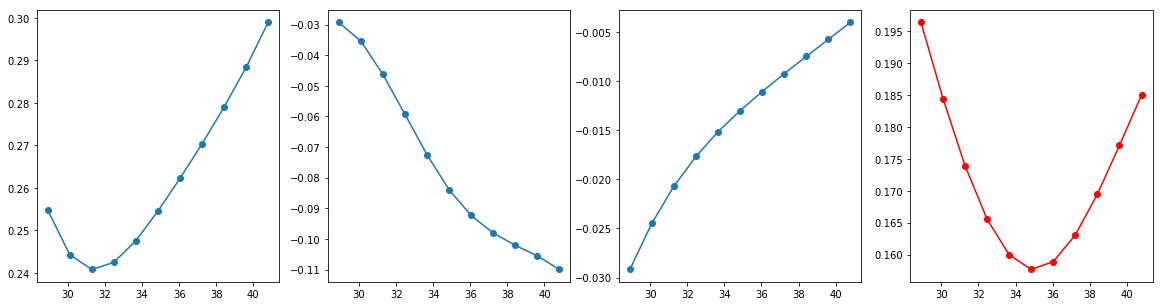

In [145]:
from scipy import interpolate
fig, axes = plt.subplots(1,4,figsize=(20,5))
ss =np.linspace(34*0.85, 34*1.2, 5)
ss2 = np.linspace(34*0.85, 34*1.2, 11)

dd = [x[0,0] for x in deltas_zc]
yy = interpolate.spline(ss,dd,ss2)
axes[0].plot(ss2,yy,'o-')
dd = [x[0,0] for x in deltas_boc]
yy = interpolate.spline(ss,dd,ss2)
axes[1].plot(ss2,yy,'o-')
dd = [x[0,0] for x in deltas_ki]
yy = interpolate.spline(ss,dd,ss2)
axes[2].plot(ss2,yy,'o-')
dd = [x[0,0] for x in deltas]
yy = interpolate.spline(ss,dd,ss2)
axes[3].plot(ss2,yy,'o-', color='red')



In [148]:
deltas2 = []
deltas_zc2 = []
deltas_boc2 = []
deltas_ki2 = []
drivers = np.random.multivariate_normal(np.array(
        [0] * (2 * n_assets)), mv_hes_mkt_implied.cov, (64, 1000))

for s1 in np.linspace(15*0.85, 15*1.2, 5):
    s_0 = np.array([34, 15, 25])
    s_0[1] = s1
    

    paths = mv_hes_mkt_implied.simulate_paths_cfb_given_dW(
        n_paths=1000, n_nodes=64, T=2, dS=1e-4, S0=s_0, dWs=drivers)

    SSc, SSf, SSb, XXc, XXf, XXb, VV = paths_mkt_implied
    paths_c = (SSc, XXc, VV)

    zcollar = structure['Zero Collar']
    zcollar.spots = s_0
    boc = structure['Best of Call']
    boc.S_init = s_0
    ki = structure['Best of KI Put']
    ki.S_init = s_0

    delta_zcollar = zcollar.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_boc = boc.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_KI = ki.mc_delta(spots=s_0, pre_computed_paths=paths)
    dd = np.diag(delta_zcollar)*x - delta_boc + delta_KI
    print(np.diag(delta_zcollar))
    print(delta_boc)
    print(delta_KI)
    print(dd, np.diag(delta_zcollar))
    deltas2.append(dd)
    deltas_zc2.append(delta_zcollar*x[0])
    deltas_boc2.append(-delta_boc)
    deltas_ki2.append(delta_KI)

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (13 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:07

[-0.63864387 -0.21992749 -0.57063849]
[[0.07619014 0.13514433 0.40542571]]
[[-0.00946061 -0.9473534  -0.18018294]]
[[0.16980679 0.17108894 0.45865979]] [-0.63864387 -0.21992749 -0.57063849]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.63864387 -0.1900405  -0.57063849]
[[0.07619014 0.45468841 0.40542571]]
[[-0.00946061 -0.64618168 -0.18018294]]
[[ 0.16980679 -0.01763924  0.45865979]] [-0.63864387 -0.1900405  -0.57063849]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.63864387 -0.21137482 -0.57063849]
[[0.07619014 0.68781767 0.40542571]]
[[-0.00946061 -0.55517302 -0.18018294]]
[[ 0.16980679 -0.03815422  0.45865979]] [-0.63864387 -0.21137482 -0.57063849]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (13 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.63864387 -0.23706252 -0.57063849]
[[0.07619014 0.80990448 0.40542571]]
[[-0.00946061 -0.46285036 -0.18018294]]
[[0.16980679 0.07850154 0.45865979]] [-0.63864387 -0.23706252 -0.57063849]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08


[-0.63864387 -0.33004775 -0.57063849]
[[0.07619014 1.20309012 0.40542571]]
[[-0.00946061 -0.26810886 -0.18018294]]
[[0.16980679 0.41007317 0.45865979]] [-0.63864387 -0.33004775 -0.57063849]


In [158]:
deltas3 = []
deltas_zc3 = []
deltas_boc3 = []
deltas_ki3 = []
drivers = np.random.multivariate_normal(np.array(
        [0] * (2 * n_assets)), mv_hes_mkt_implied.cov, (64, 1000))

for s1 in np.linspace(25*0.8, 25*1.2, 5):
    s_0 = np.array([34, 15, 25])
    s_0[2] = s1
    

    paths = mv_hes_mkt_implied.simulate_paths_cfb_given_dW(
        n_paths=1000, n_nodes=64, T=2, dS=1e-4, S0=s_0, dWs=drivers)

    SSc, SSf, SSb, XXc, XXf, XXb, VV = paths_mkt_implied
    paths_c = (SSc, XXc, VV)

    zcollar = structure['Zero Collar']
    zcollar.spots = s_0
    boc = structure['Best of Call']
    boc.S_init = s_0
    ki = structure['Best of KI Put']
    ki.S_init = s_0

    delta_zcollar = zcollar.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_boc = boc.mc_delta(spots=s_0, pre_computed_paths=paths)
    delta_KI = ki.mc_delta(spots=s_0, pre_computed_paths=paths)
    dd = np.diag(delta_zcollar)*x - delta_boc + delta_KI
    print(np.diag(delta_zcollar))
    print(delta_boc)
    print(delta_KI)
    print(dd, np.diag(delta_zcollar))
    deltas3.append(dd)
    deltas_zc3.append(delta_zcollar*x[0])
    deltas_boc3.append(-delta_boc)
    deltas_ki3.append(delta_KI)

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.63951309 -0.19243267 -0.6325704 ]
[[0.08148598 0.50717641 0.24810398]]
[[-0.00794463 -0.54610785 -0.2443391 ]]
[[0.16637463 0.04358196 0.66516076]] [-0.63951309 -0.19243267 -0.6325704 ]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.63951309 -0.19243267 -0.59056702]
[[0.08148598 0.50717641 0.3214916 ]]
[[-0.00794463 -0.54610785 -0.19713381]]
[[0.16637463 0.04358196 0.56211224]] [-0.63951309 -0.19243267 -0.59056702]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:08 Time: 0:00:08
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.63951309 -0.19243267 -0.57983918]
[[0.08148598 0.50717641 0.4249601 ]]
[[-0.00794463 -0.54610785 -0.1462438 ]]
[[0.16637463 0.04358196 0.48990181]] [-0.63951309 -0.19243267 -0.57983918]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:07 Time: 0:00:07
  1% (12 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

[-0.63951309 -0.19243267 -0.59923838]
[[0.08148598 0.50717641 0.49748217]]
[[-0.00794463 -0.54610785 -0.1103787 ]]
[[0.16637463 0.04358196 0.48874536]] [-0.63951309 -0.19243267 -0.59923838]


100% (1000 of 1000) |#####################| Elapsed Time: 0:00:09 Time: 0:00:09


[-0.63951309 -0.19243267 -0.66389157]
[[0.08148598 0.50717641 0.57945873]]
[[-0.00794463 -0.54610785 -0.0975196 ]]
[[0.16637463 0.04358196 0.53794324]] [-0.63951309 -0.19243267 -0.66389157]


In [156]:
[x[0,2] for x in deltas3]

[0.567177268382979,
 0.5545180489307633,
 0.49066321138609004,
 0.5139581251503378,
 0.5537929592026813]

In [172]:
from heston import EuropeanPut
p1 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[0]], 30, 0.5)
p2 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[1]], 10, 0.5)
p3 = EuropeanPut(mv_hes_mkt_implied.univariates[assets[2]], 20, 0.5)
p1.delta(30)

-0.367957404137087

In [187]:
deltas

[array([[0.21458041, 0.21118765, 0.46817153]]),
 array([[0.18341228, 0.21118765, 0.46817153]]),
 array([[0.15898593, 0.21118765, 0.46817153]]),
 array([[0.16085202, 0.21118765, 0.46817153]]),
 array([[0.17371455, 0.21118765, 0.46817153]]),
 array([[0.15898593, 0.21118765, 0.46817153]])]

In [188]:
deltas_after_hedge

[]

/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  del sys.path[0]
/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


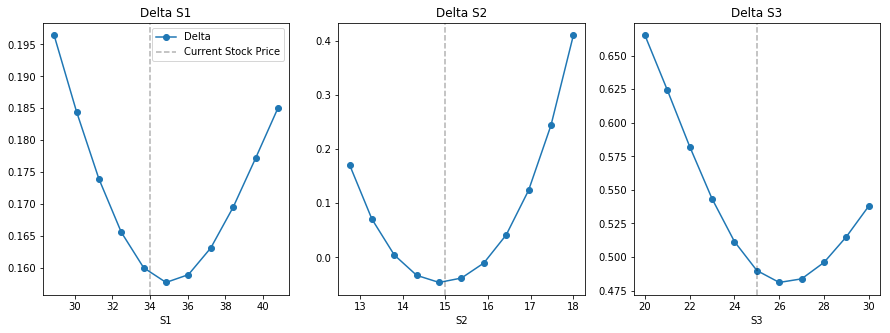

In [168]:
from scipy import interpolate
fig, axes = plt.subplots(1,3,figsize=(15,5))
ss =np.linspace(34*0.85, 34*1.2, 5)
ss2 = np.linspace(34*0.85, 34*1.2, 11)
dd = [x[0,0] for x in deltas]
yy = interpolate.spline(ss,dd,ss2)
axes[0].plot(ss2,yy,'o-', label='Delta')
#axes[0].plot(ss,dd,'o-')

ss =np.linspace(15*0.85, 15*1.2, 5)
ss2 = np.linspace(15*0.85, 15*1.2, 11)
dd = [x[0,1] for x in deltas2]
yy = interpolate.spline(ss,dd,ss2)
axes[1].plot(ss2,yy,'o-')
#axes[1].plot(ss,dd,'o-')

ss =np.linspace(25*0.8, 25*1.2, 5)
ss2 = np.linspace(25*0.8, 25*1.2, 11)
dd = [x[0,2] for x in deltas3]
yy = interpolate.spline(ss,dd,ss2)
axes[2].plot(ss2,yy,'o-')
#axes[2].plot(ss,dd,'o-')
axes[0].set_title('Delta S1')
axes[1].set_title('Delta S2')
axes[2].set_title('Delta S3')
axes[0].set_xlabel('S1')
axes[1].set_xlabel('S2')
axes[2].set_xlabel('S3')
axes[0].axvline(34, linestyle='--', color='black', alpha=0.3, label='Current Stock Price')
axes[1].axvline(15, linestyle='--', color='black', alpha=0.3)
axes[2].axvline(25, linestyle='--', color='black', alpha=0.3)
axes[0].legend()


/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """


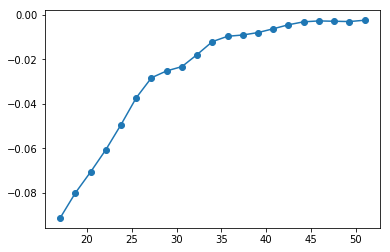

In [107]:
from scipy import interpolate
dd = [x[0,0] for x in deltas_ki]
ss =np.linspace(34*0.5, 34*1.5, 11)
ss2 = np.linspace(34*0.5, 34*1.5, 21)
yy = interpolate.spline(ss,dd,ss2)
plt.plot(ss2,yy,'o-')

/Users/zed/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """


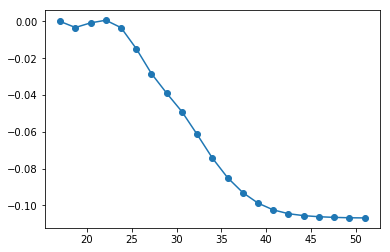

In [119]:
from scipy import interpolate
dd = [x[0,0] for x in deltas_boc]
ss =np.linspace(34*0.5, 34*1.5, 11)
ss2 = np.linspace(34*0.5, 34*1.5, 21)
yy = interpolate.spline(ss,dd,ss2)
plt.plot(ss2,yy,'o-')

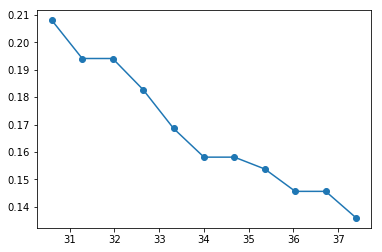

In [77]:
ss = np.linspace(34*0.9, 34*1.1, 11)
dd = [d[0,0] for d in deltas]
plt.plot(ss,dd,'o-')

## Valuation under Market Implied Surface $\mathcal{M}_0$

In [19]:
SSc, SSf, SSb, XXc, XXf, XXb, VV = paths_mkt_implied
paths_c = (SSc, XXc, VV)
zcollar = structure['Zero Collar']
boc = structure['Best of Call']
ki = structure['Best of KI Put']
x = zcollar.shares
px_zcollar, se = zcollar.mc_price(spots=s_0, pre_computed_paths=paths_c)
px_boc, se = boc.mc_price(spots=s_0, pre_computed_paths=paths_c)
px_KI, se = ki.mc_price(spots=s_0, pre_computed_paths=paths_c)
value = np.sum(px_zcollar*x) - px_boc + px_KI
print(px_zcollar, px_boc, px_KI)


[-0.2 -0.1 -0.2] 4.742748641558115 3.846027650581639


In [51]:
SSc, SSf, SSb, XXc, XXf, XXb, VV = paths_mkt_implied
paths_c = (SSc, XXc, VV)
zcollar = structure['Zero Collar']
boc = structure['Best of Call']
ki = structure['Best of KI Put']
px_zcollar, se = zcollar.mc_price(spots=s_0, pre_computed_paths=paths_c)
print('Collar', px_zcollar, se)
px_pl, se = zcollar.put_leg.mc_price(spots=s_0, pre_computed_paths=paths_c)
print('put leg', px_pl, se)
px_cl, se = zcollar.call_leg.mc_price(spots=s_0, pre_computed_paths=paths_c)
print('call leg', px_cl, se)
px_boc, se = boc.mc_price(spots=s_0, pre_computed_paths=paths_c)
print('boc',px_boc, se)
px_KI, se = ki.mc_price(spots=s_0, pre_computed_paths=paths_c)
print('KI',px_KI, se)
value = np.sum(px_zcollar*x) - px_boc + px_KI
print(value)

Collar [-0.2 -0.1 -0.2] [0.2154492  0.05564433 0.21723374]
put leg [1.91266293 0.19676318 1.79749833] [0.11972758 0.02216756 0.10292881]
call leg [2.11266293 0.29676318 1.99749833] [0.14969369 0.04964952 0.16732884]
boc 4.742748641558115 0.3716526893729494
KI 6.757598641558048 0.5617711028243777
3.0308499999510654


In [35]:
px_boc, se = boc.mc_price(spots=s_0, pre_computed_paths=paths_c)
print('boc',px_boc, se)

boc 4.742748641558115 0.3716526893729494


In [56]:
for k in [0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.6]:
    ki.Ks = k*np.array([31.5,  10.05, 22.  ])
    ki.Hs = ki.Ks-np.array([2,2,2])
    px_KI, se = ki.mc_price(spots=s_0, pre_computed_paths=paths_c)
    print('KI',px_KI, se, ki.Ks)

KI 0.04514073708679361 0.021291198449428998 [15.75   5.025 11.   ]
KI 0.22197999461051568 0.055333386150070635 [22.05   7.035 15.4  ]
KI 0.6897577766759214 0.10848671277145785 [28.35   9.045 19.8  ]
KI 1.476281412029917 0.17642101502472043 [34.65  11.055 24.2  ]
KI 2.688247846155747 0.2566041851546343 [40.95  13.065 28.6  ]
KI 4.384859317549295 0.34642270917365425 [47.25  15.075 33.   ]
KI 5.381416415505892 0.39421379181957567 [50.4  16.08 35.2 ]


In [50]:
px_KI, px_boc, px_zcollar

(5.084278925225566,
 4.1081789252255225,
 array([0.00000000e+00, 1.88646971e-16, 1.65398911e-15]))